In [1]:
from scipy import stats
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'serif'

## Implied Volatilities


In [3]:
def BSM_CALL_VALUE(S0, K, T, r, sigma):
    d1 = 1/(sigma*(T)**0.5)*(np.log(S0/K) + (r+sigma**2/2)*(T))
    d2 = 1/(sigma*(T)**0.5)*(np.log(S0/K) + (r-sigma**2/2)*(T))
    C = S0*stats.norm.cdf(d1) - K*np.exp(-r*(T))*stats.norm.cdf(d2)
    return C

def BSM_VEGA(S0, K, T, r, sigma):
    d1 = 1/(sigma*(T)**0.5)*(np.log(S0/K) + (r+sigma**2/2)*(T))
    vega = S0*stats.norm.cdf(d1)*T**0.5
    return vega

def BSM_CALL_IMPLIED_VOL(S0, K, T, r, C0, sigma_est, ita=100):
    for i in range(ita):
        sigma_est -= (BSM_CALL_VALUE(S0, K, T, r, sigma_est) - C0) / BSM_VEGA(S0, K, T, r, sigma_est)
    return sigma_est

In [8]:
h5 = pd.HDFStore('./source/vstoxx_data_31032014.h5', 'r')
futures_data = h5['futures_data']
options_data = h5['options_data']
h5.close()

futures_data['DATE'] = futures_data['DATE'].apply(lambda x: dt.datetime.fromtimestamp(x/1e9))
futures_data['MATURITY'] = futures_data['MATURITY'].apply(lambda x: dt.datetime.fromtimestamp(x/1e9))

options_data['DATE'] = options_data['DATE'].apply(lambda x: dt.datetime.fromtimestamp(x/1e9))
options_data['MATURITY'] = options_data['MATURITY'].apply(lambda x: dt.datetime.fromtimestamp(x/1e9))

In [12]:
V0 = 17.6639
r = 0.01
options_data['IMP_VOL'] = 0
tol = 0.5
for option in options_data.index:
    
    forward = futures_data[futures_data['MATURITY']==options_data.loc[option]['MATURITY']]['PRICE'].values[0]
      # picking the right futures value
    if (forward * (1 - tol) < options_data.loc[option]['STRIKE'] < forward * (1 + tol)):
        options_data.loc[option, 'IMP_VOL'] = BSM_CALL_IMPLIED_VOL(V0, 
                                                                   options_data.loc[option, 'STRIKE'],
                                                                   options_data.loc[option, 'TTM'],
                                                                   r,
                                                                   options_data.loc[option, 'PRICE'],
                                                                   sigma_est=2
                                                                  )

In [13]:
plot_data = options_data[options_data['IMP_VOL'] > 0]
plot_data = pd.pivot_table(plot_data, values='IMP_VOL', index='STRIKE', columns='MATURITY')

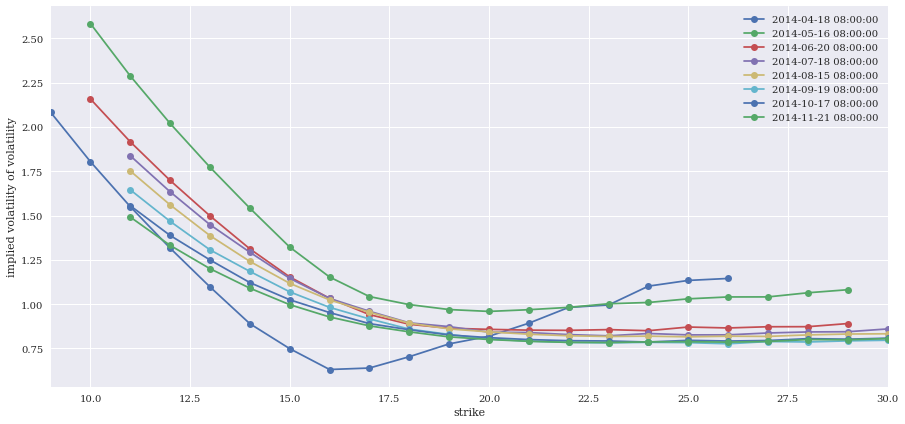

In [14]:
plot_data.plot(style='-o', figsize=(15, 7))
plt.xlabel('strike')
plt.ylabel('implied volatility of volatility')
plt.legend()
plt.show()

## Monte Carlo Simulation

In [15]:
S0 = 100
K = 105
T = 1
r = 0.05
sigma = 0.2
BSM_CALL_VALUE(S0, K, T, r, sigma)

8.021352235143176

In [32]:
M = 50
dt = T / M
n = 20000
S = np.zeros(n)
for i in range(n):
    st = S0
    for j in range(M+1):
        w = np.random.randn()
        st *= np.exp((r-sigma**2/2)*dt + sigma*dt**0.5*w)
    S[i] = st

h = S - K
h[h<0] = 0

C = np.exp(-r*T)*h.mean()
C

8.199854073338471